# FABRIC Setup

In this notebook, you will pick up where you left off after creating a FABRIC account, joining a FABRIC project. Now, you will learn how to:

-   Configure your Jupyter environment in FABRIC (this is a one-time configuration)
-   Reserve resources on FABRIC
-   Configure your reserved resources
-   Access your reserved resources over SSH
-   Retrieving files saved on a FABRIC resources
-   Extend your FABRIC reservation (in case you need more time) or delete it (in case you finish early)

### Configure your Jupyter environment

You should now be inside the Jupyter environment in FABRIC. Before you use this environment for the first time, you’ll want to create some configuration files that tell it who you are, what project you belong to, and what key it should use to access your resource on FABRIC.

First, we will need to generate some keys! On FABRIC, we access the resources (hosts, switches, routers) in our experiment by connecting to a server known as a “bastion” over an SSH connection, and then connecting from the “bastion” to the device that we want to use. Both “hops” will be over SSH, a secure protocol for remote login, and both hops will use an SSH *key* for authentication. Using SSH key authentication to connect to a remote system is a more secure alternative to logging in with an account password.

SSH key authentication uses a pair of separate keys (i.e., a key pair): one “private” key, which you keep a secret, and the other “public”. A key pair has a special property: any message that is encrypted with your private key can only be decrypted with your public key, and any message that is encrypted with your public key can only be decrypted with your private key.

This property can be exploited for authenticating login to a remote machine. First, the public key is uploaded to a specific location on the remote machine. Then, when you want to log in to the machine:

1.  You use a special argument with your SSH command to let your SSH application know that you are going to use a key, and the location of your private key. If the private key is protected by a passphrase, you may be prompted to enter the passphrase (this is not a password for the remote machine, though).
2.  The machine you are logging in to will ask your SSH client to “prove” that it owns the (secret) private key that matches an authorized public key. To do this, the machine will send a random message to you.
3.  Your SSH client will encrypt the random message with the private key and send it back to the remote machine.
4.  The remote machine will decrypt the message with your public key. If the decrypted message matches the message it sent you, it has “proof” that you are in possession of the private key for that key pair, and will grant you access (without using an account password on the remote machine.)

(Of course, this relies on you keeping your private key a secret.)

To access resources in our FABRIC experiments, we will use a “bastion key” to authenticate on the “hop” to the “bastion”, and then a “slice key” to authenticate on the hop from the “bastion” to the FABRIC resource. In this exercise, we’ll prepare both of those keys, then tell the FABRIC Jupyter environment where to find them and how to use them.

First, we will use the FABRIC Portal to generate the bastion key. In the [FABRIC Portal](https://portal.fabric-testbed.net/), log in and then click on “User Profile” in the menu bar at the top. Then, click “My SSH Keys” and “Manage SSH Keys”.

![](images/fabric-manage-ssh-keys.png)

Click on the “Bastion” tab, then scroll down to the “Generate Bastion Key Pair” section. Set the “Name” to `fabric_bastion_key`, exactly as shown here. You can write anything you want in the “Description” field.

![](images/fabric-gen-bastion.png)

Then, click “Generate”.

A small pop-up will show the following message:

![](images/fabric-key-popup.png)

Click on the “Download” button next to “Private Key” and click on the “Download” button next to “Public Key” to download *both* parts of your new SSH key pair.

Find the two files, “fabric_bastion_key” and “fabric_bastion_key.pub” in your browser’s regular download folder. You will need these keys - make sure to save them in a safe place!

Now, switch back to your Jupyter environment. In the sidebar on the left side of this environment is a file browser. You will see a directory named `fabric_config` there - double-click on it to navigate to this directory.

![](images/jup-fabconfig-dir.png)

You will see that the part of the interface that shows your current position in the filesystem (highlighted in blue in the image below) changes to reflect that you are inside the `fabric_config` directory. Then, click on the upload button (highlighted in green).

![](images/jup-upload-keys.png)

Upload the two files, “fabric_bastion_key” and “fabric_bastion_key.pub”, to this directory in the Jupyter environment.

You’re almost ready to finish configuring your Jupyter environment now! But first, you need to find two pieces of information from the FABRIC Portal.

**Your bastion username**: In the FABRIC Portal, click on “User Profile” and then “My SSH Keys”. Find the “Bastion login” (shown highlighted in the image below) and make a note of it - you can click on the small icon right next to it to copy it, then paste it somewhere else.

![](images/fabric-bastion-username.png)

**Your project ID**: In the FABRIC Portal, click on “User Profile” and then “My Roles and Projects”. Select your project, then scroll down and find the “Project ID”, then copy it.

![](images/fab-project-id.png)

Now you are ready! In the following cell, fill in your bastion username and project ID instead of the `...`:

In [1]:
%env FABRIC_BASTION_USERNAME hun13_0000132578
%env FABRIC_PROJECT_ID a045503e-d19d-434e-93b1-08b8aad3d5d1

env: FABRIC_BASTION_USERNAME=hun13_0000132578
env: FABRIC_PROJECT_ID=a045503e-d19d-434e-93b1-08b8aad3d5d1


We’ll keep all of our FABRIC configuration files at the default locations, specified in the next cell:

In [2]:
!mkdir -p /home/fabric/work/fabric_config
%env FABRIC_BASTION_PRIVATE_KEY_LOCATION /home/fabric/work/fabric_config/fabric_bastion_key
%env FABRIC_BASTION_SSH_CONFIG_FILE /home/fabric/work/fabric_config/ssh_config
%env FABRIC_RC_FILE /home/fabric/work/fabric_config/fabric_rc
%env FABRIC_TOKEN_FILE /home/fabric/.tokens.json
%env FABRIC_SLICE_PRIVATE_KEY_FILE /home/fabric/work/fabric_config/slice_key
%env FABRIC_SLICE_PUBLIC_KEY_FILE /home/fabric/work/fabric_config/slice_key.pub

env: FABRIC_BASTION_PRIVATE_KEY_LOCATION=/home/fabric/work/fabric_config/fabric_bastion_key
env: FABRIC_BASTION_SSH_CONFIG_FILE=/home/fabric/work/fabric_config/ssh_config
env: FABRIC_RC_FILE=/home/fabric/work/fabric_config/fabric_rc
env: FABRIC_TOKEN_FILE=/home/fabric/.tokens.json
env: FABRIC_SLICE_PRIVATE_KEY_FILE=/home/fabric/work/fabric_config/slice_key
env: FABRIC_SLICE_PUBLIC_KEY_FILE=/home/fabric/work/fabric_config/slice_key.pub


Now, we’ll generate a new “slice key” pair. (This is used on the “hop” from the bastion, to our FABRIC resources.)

Note that this cell will appear to prompt you for a response (whether or not to overwrite the existing key pair), but a response will be sent automatically - you don’t have to do anything.

In [3]:
!ssh-keygen -t rsa -b 3072 -f $FABRIC_SLICE_PRIVATE_KEY_FILE -q -N "" <<< y

/home/fabric/work/fabric_config/slice_key already exists.
Overwrite (y/n)? 

and we’ll make sure the file permissions are set correctly on both private keys:

In [4]:
%%bash
chmod 600 ${FABRIC_BASTION_PRIVATE_KEY_LOCATION}
chmod 600 ${FABRIC_SLICE_PRIVATE_KEY_FILE}

The following cell creates the `fabric_rc` configuration file using the values specified above. In the future, when we use FABRIC, we will load our configuration from this file.

In [5]:
%%bash
cat <<EOF > ${FABRIC_RC_FILE}
export FABRIC_CREDMGR_HOST=cm.fabric-testbed.net
export FABRIC_ORCHESTRATOR_HOST=orchestrator.fabric-testbed.net

export FABRIC_PROJECT_ID=${FABRIC_PROJECT_ID}
export FABRIC_TOKEN_LOCATION=${FABRIC_TOKEN_FILE}

export FABRIC_BASTION_HOST=bastion.fabric-testbed.net
export FABRIC_BASTION_USERNAME=${FABRIC_BASTION_USERNAME}

export FABRIC_BASTION_KEY_LOCATION=${FABRIC_BASTION_PRIVATE_KEY_LOCATION}
#export FABRIC_BASTION_KEY_PASSPHRASE=

export FABRIC_SLICE_PRIVATE_KEY_FILE=${FABRIC_SLICE_PRIVATE_KEY_FILE}
export FABRIC_SLICE_PUBLIC_KEY_FILE=${FABRIC_SLICE_PUBLIC_KEY_FILE} 
#export FABRIC_SLICE_PRIVATE_KEY_PASSPHRASE=

export FABRIC_LOG_FILE=${HOME}/fablib.log
export FABRIC_LOG_LEVEL=INFO 

export FABRIC_AVOID=''

export FABRIC_SSH_COMMAND_LINE="ssh -i {{ _self_.private_ssh_key_file }} -F ${HOME}/work/fabric_config/ssh_config {{ _self_.username }}@{{ _self_.management_ip }}"
EOF

Finally, we also create an SSH configuration file, which we’ll use in the future to access our FABRIC resources using SSH.

In [6]:
%%bash
cat <<EOF > ${FABRIC_BASTION_SSH_CONFIG_FILE}
UserKnownHostsFile /dev/null
StrictHostKeyChecking no
ServerAliveInterval 120 

Host bastion.fabric-testbed.net
     User ${FABRIC_BASTION_USERNAME}
     ForwardAgent yes
     Hostname %h
     IdentityFile ${FABRIC_BASTION_PRIVATE_KEY_LOCATION}
     IdentitiesOnly yes

Host * !bastion.fabric-testbed.net
     ProxyJump ${FABRIC_BASTION_USERNAME}@bastion.fabric-testbed.net:22
EOF

## Reserve resources

In this exercise, we will reserve and use resources on FABRIC: two hosts on two different network segments, connected by a router. (Both the hosts and the router will be realized as Linux virtual machines.)

This involves several steps -

-   **Configure environment**: Now that you have configured your Jupyter environment on FABRIC, you can load it from the configuration file at the beginning of each experiment! Check the output of the following cell, and make sure it reflects your configuration (e.g. correct bastion hostname, etc.).
-   **Define configuration for this experiment**: Next, you will define the configuration of the experiment, with all of the properties of the virtual machines, network interfaces, and networks that you will request from the FABRIC infrastructure.
-   **Reserve resources**: At this stage, you are ready to reserve resources! You will construct a “slice” following the configuration you defined, and then submit it to FABRIC to build out on the physical infrastructure. (This may take some time.)
-   **Configure resources**: Also following the configuration you defined, you will configure network interfaces on the resources, install software, or do other configuration tasks that are necessary for your experiment.
-   **Draw the network topology**: We can visualize the network topology, including the names, MAC addresses, and IP addresses of each network interface, directly in this notebook.
-   **Log in to resources**: Finally, you will get the SSH login details for each of the nodes in your topology.

### Configure environment

In [7]:
from fabrictestbed_extensions.fablib.fablib import FablibManager as fablib_manager
fablib = fablib_manager() 
conf = fablib.show_config()

User: HUN13@pitt.edu bastion key is valid!
Configuration is valid


Credential Manager,cm.fabric-testbed.net
Orchestrator,orchestrator.fabric-testbed.net
Project ID,a045503e-d19d-434e-93b1-08b8aad3d5d1
Token File,/home/fabric/.tokens.json
Bastion Host,bastion.fabric-testbed.net
Bastion Username,hun13_0000132578
Bastion Private Key File,/home/fabric/work/fabric_config/fabric_bastion_key
Slice Private Key File,/home/fabric/work/fabric_config/slice_key
Slice Public Key File,/home/fabric/work/fabric_config/slice_key.pub
Log File,/tmp/fablib/fablib.log
Log Level,INFO


### Define configuration for this experiment

In [8]:
slice_name="hello-fabric_" + fablib.get_bastion_username()

node_conf = [
 {'name': "romeo",   'cores': 2, 'ram': 4, 'disk': 10, 'image': 'default_ubuntu_22', 'packages': ['net-tools']}, 
 {'name': "juliet",  'cores': 2, 'ram': 4, 'disk': 10, 'image': 'default_ubuntu_22', 'packages': ['net-tools']}, 
 {'name': "router",  'cores': 2, 'ram': 4, 'disk': 10, 'image': 'default_ubuntu_22', 'packages': ['net-tools']}
]
net_conf = [
 {"name": "net0", "subnet": "10.0.0.0/24", "nodes": [{"name": "romeo",   "addr": "10.0.0.2"}, {"name": "router", "addr": "10.0.0.1"}]},
 {"name": "net1", "subnet": "10.0.1.0/24", "nodes": [{"name": "juliet",   "addr": "10.0.1.2"}, {"name": "router", "addr": "10.0.1.1"}]}
]
route_conf = [
 {"addr": "10.0.1.0/24", "gw": "10.0.0.1", "nodes": ["romeo"]}, 
 {"addr": "10.0.0.0/24", "gw": "10.0.1.1", "nodes": ["juliet"]}
]
exp_conf = {'cores': sum([ n['cores'] for n in node_conf]), 'nic': sum([len(n['nodes']) for n in net_conf]) }

### Reserve resources

Now, we are ready to reserve resources!

First, make sure you don’t already have a slice with this name:

In [9]:
try:
    slice = fablib.get_slice(slice_name)
    print("You already have a slice by this name!")
    print("If you previously reserved resources, skip to the 'log in to resources' section.")
except:
    print("You don't have a slice named %s yet." % slice_name)
    print("Continue to the next step to make one.")
    slice = fablib.new_slice(name=slice_name)

You don't have a slice named hello-fabric_hun13_0000132578 yet.
Continue to the next step to make one.


We will reserve resources for our experiment at the EDUKY site:

In [10]:
site_name = 'EDUKY'
fablib.show_site(site_name)

Name,EDUKY
State,Active
Address,"301 Hilltop Avenue,Lexington, KY 40506"
Location,"(38.0325, -84.502801)"
PTP Capable,True
Hosts,18
CPUs,36
Cores Available,73728
Cores Capacity,73728
Cores Allocated,0
Ram Available,8604


'<pandas.io.formats.style.Styler object at 0x7bd0882f4950>'

Then we will add hosts and network segments:

In [11]:
# this cell sets up the nodes
for n in node_conf:
    slice.add_node(name=n['name'], site=site_name, 
                   cores=n['cores'], 
                   ram=n['ram'], 
                   disk=n['disk'], 
                   image=n['image'])

In [12]:
# this cell sets up the network segments
for n in net_conf:
    ifaces = [slice.get_node(node["name"]).add_component(model="NIC_Basic", 
                                                 name=n["name"]).get_interfaces()[0] for node in n['nodes'] ]
    slice.add_l2network(name=n["name"], type='L2Bridge', interfaces=ifaces)

The following cell submits our request to the FABRIC site. The output of this cell will update automatically as the status of our request changes.

-   While it is being prepared, the “State” of the slice will appear as “Configuring”.
-   When it is ready, the “State” of the slice will change to “StableOK”.

You may prefer to walk away and come back in a few minutes (for simple slices) or a few tens of minutes (for more complicated slices with many resources).

In [13]:
slice.submit()


Retry: 9, Time: 234 sec


ID,ca9b224e-f300-448b-bf65-47067046646d
Name,hello-fabric_hun13_0000132578
Lease Expiration (UTC),2025-08-21 19:05:33 +0000
Lease Start (UTC),2025-08-20 19:05:33 +0000
Project ID,a045503e-d19d-434e-93b1-08b8aad3d5d1
State,StableOK
Email,HUN13@pitt.edu
UserId,0d94c21b-92a3-4e56-84de-be18169665eb


ID,Name,Cores,RAM,Disk,Image,Image Type,Host,Site,Username,Management IP,State,Error,SSH Command,Public SSH Key File,Private SSH Key File
beddcfc3-1b2d-4486-9aa8-1266107e7ced,juliet,2,4,10,default_ubuntu_22,qcow2,eduky-w16.fabric-testbed.net,EDUKY,ubuntu,2610:1e0:1700:206:f816:3eff:febe:c17c,Active,,ssh -i /home/fabric/work/fabric_config/slice_key -F /home/fabric/work/fabric_config/ssh_config ubuntu@2610:1e0:1700:206:f816:3eff:febe:c17c,/home/fabric/work/fabric_config/slice_key.pub,/home/fabric/work/fabric_config/slice_key
fe622b3b-017c-400f-8966-47a21da7f450,romeo,2,4,10,default_ubuntu_22,qcow2,eduky-w4.fabric-testbed.net,EDUKY,ubuntu,2610:1e0:1700:206:f816:3eff:fe59:556c,Active,,ssh -i /home/fabric/work/fabric_config/slice_key -F /home/fabric/work/fabric_config/ssh_config ubuntu@2610:1e0:1700:206:f816:3eff:fe59:556c,/home/fabric/work/fabric_config/slice_key.pub,/home/fabric/work/fabric_config/slice_key
cff3ced8-f8fc-4fec-8bcd-678c374140b2,router,2,4,10,default_ubuntu_22,qcow2,eduky-w6.fabric-testbed.net,EDUKY,ubuntu,2610:1e0:1700:206:f816:3eff:fe64:aed9,Active,,ssh -i /home/fabric/work/fabric_config/slice_key -F /home/fabric/work/fabric_config/ssh_config ubuntu@2610:1e0:1700:206:f816:3eff:fe64:aed9,/home/fabric/work/fabric_config/slice_key.pub,/home/fabric/work/fabric_config/slice_key


ID,Name,Layer,Type,Site,Subnet,Gateway,State,Error
100dd985-4b17-4b2d-b992-a441cb06be11,net0,L2,L2Bridge,EDUKY,None,None,Active,
9cfd5cca-57f1-4b4a-a7c9-62bdc0dd5739,net1,L2,L2Bridge,EDUKY,None,None,Active,


Name,Short Name,Node,Network,Bandwidth,Mode,VLAN,MAC,Physical Device,Device,IP Address,Numa Node,Switch Port
romeo-net0-p1,p1,romeo,net0,100,config,,02:03:DF:B6:AD:B3,enp7s0,enp7s0,fe80::3:dfff:feb6:adb3,1,HundredGigE0/0/0/4
juliet-net1-p1,p1,juliet,net1,100,config,,02:65:5B:30:77:C2,enp7s0,enp7s0,fe80::65:5bff:fe30:77c2,1,HundredGigE0/0/0/16
router-net1-p1,p1,router,net1,100,config,,02:5A:9F:4B:87:1F,enp7s0,enp7s0,fe80::5a:9fff:fe4b:871f,1,HundredGigE0/0/0/24
router-net0-p1,p1,router,net0,100,config,,06:54:D2:B8:FE:41,enp8s0,enp8s0,fe80::454:d2ff:feb8:fe41,1,HundredGigE0/0/0/24



Time to print interfaces 241 seconds


'ca9b224e-f300-448b-bf65-47067046646d'

In [14]:
slice.get_state()
slice.wait_ssh(progress=True)

Waiting for slice . Slice state: StableOK
Waiting for ssh in slice . ssh successful


True

### Configure resources

Next, we will configure the resources so they are ready to use.

In [15]:
slice = fablib.get_slice(name=slice_name)

In [16]:
# install packages
# this will take a while and will run in background while you do other steps
for n in node_conf:
    if len(n['packages']):
        node = slice.get_node(n['name'])
        pkg = " ".join(n['packages'])
        node.execute_thread("sudo apt update; sudo DEBIAN_FRONTEND=noninteractive apt -y install %s" % pkg)

In [17]:
# bring interfaces up and either assign an address (if there is one) or flush address
from ipaddress import ip_address, IPv4Address, IPv4Network

for net in net_conf:
    for n in net['nodes']:
        if_name = n['name'] + '-' + net['name'] + '-p1'
        iface = slice.get_interface(if_name)
        iface.ip_link_up()
        if n['addr']:
            iface.ip_addr_add(addr=n['addr'], subnet=IPv4Network(net['subnet']))
        else:
            iface.get_node().execute("sudo ip addr flush dev %s"  % iface.get_device_name())

In [18]:
# make sure all interfaces are brought up
for iface in slice.get_interfaces():
    iface.ip_link_up()

In [19]:
# prepare a "hosts" file that has names and addresses of every node
hosts_txt = [ "%s\t%s" % ( n['addr'], n['name'] ) for net in net_conf  for n in net['nodes'] if type(n) is dict and n['addr']]
for n in slice.get_nodes():
    for h in hosts_txt:
        n.execute("echo %s | sudo tee -a /etc/hosts" % h)

10.0.0.2 romeo
10.0.0.1 router
10.0.1.2 juliet
10.0.1.1 router
10.0.0.2 romeo
10.0.0.1 router
10.0.1.2 juliet
10.0.1.1 router
10.0.0.2 romeo
10.0.0.1 router
10.0.1.2 juliet
10.0.1.1 router


In [20]:
# enable IPv4 forwarding on all nodes
for n in slice.get_nodes():
    n.execute("sudo sysctl -w net.ipv4.ip_forward=1")

net.ipv4.ip_forward = 1
net.ipv4.ip_forward = 1
net.ipv4.ip_forward = 1


In [21]:
# set up static routes
for rt in route_conf:
    for n in rt['nodes']:
        slice.get_node(name=n).ip_route_add(subnet=IPv4Network(rt['addr']), gateway=rt['gw'])

### Draw the network topology

The following cell will draw the network topology, for your reference. The interface name and addresses of each experiment interface will be shown on the drawing.

In [22]:
l2_nets = [(n.get_name(), {'color': 'lavender'}) for n in slice.get_l2networks() ]
l3_nets = [(n.get_name(), {'color': 'pink'}) for n in slice.get_l3networks() ]
hosts   =   [(n.get_name(), {'color': 'lightblue'}) for n in slice.get_nodes()]
nodes = l2_nets + l3_nets + hosts
ifaces = [iface.toDict() for iface in slice.get_interfaces()]
edges = [(iface['network'], iface['node'], 
          {'label': iface['physical_dev'] + '\n' + iface['ip_addr'] + '\n' + iface['mac']}) for iface in ifaces]

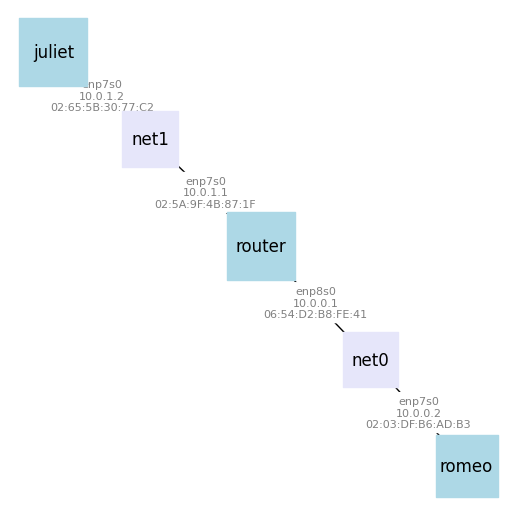

In [23]:
import networkx as nx
import matplotlib.pyplot as plt
plt.figure(figsize=(len(nodes),len(nodes)))
G = nx.Graph()
G.add_nodes_from(nodes)
G.add_edges_from(edges)
pos = nx.spring_layout(G)
nx.draw(G, pos, node_shape='s',  
        node_color=[n[1]['color'] for n in nodes], 
        node_size=[len(n[0])*400 for n in nodes],  
        with_labels=True);
nx.draw_networkx_edge_labels(G,pos,
                             edge_labels=nx.get_edge_attributes(G,'label'),
                             font_color='gray',  font_size=8, rotate=False);

### Log into resources

Now, we are finally ready to log in to our resources over SSH! Run the following cells, and observe the table output - you will see an SSH command for each of the resources in your topology.

In [24]:
import pandas as pd
pd.set_option('display.max_colwidth', None)
slice_info = [{'Name': n.get_name(), 'SSH command': n.get_ssh_command()} for n in slice.get_nodes()]
pd.DataFrame(slice_info).set_index('Name')

,SSH command
Name,
romeo,ssh -i /home/fabric/work/fabric_config/slice_key -F /home/fabric/work/fabric_config/ssh_config ubuntu@2610:1e0:1700:206:f816:3eff:fe59:556c
juliet,ssh -i /home/fabric/work/fabric_config/slice_key -F /home/fabric/work/fabric_config/ssh_config ubuntu@2610:1e0:1700:206:f816:3eff:febe:c17c
router,ssh -i /home/fabric/work/fabric_config/slice_key -F /home/fabric/work/fabric_config/ssh_config ubuntu@2610:1e0:1700:206:f816:3eff:fe64:aed9


Now, you can open an SSH session on any of the resources as follows:

-   in Jupyter, from the menu bar, use File \> New \> Terminal to open a new terminal.
-   copy an SSH command from the table, and paste it into the terminal. (Note that each SSH command is a single line, even if the display wraps the text to a second line! When you copy and paste it, paste it all together.)

You can repeat this process (open several terminals) to start a session on each resource. Each terminal session will have a tab in the Jupyter environment, so that you can easily switch between them.

## Transfer files from a FABRIC host

In future experiments, we’ll often want to save the results of an experiment to a file on a FABRIC host, then transfer it to our own laptop for further inspection and analysis. In this exercise, we will learn how to do that!

As described above, open an SSH session to the “romeo” host in your topology. On this host, run the following command:

    ping -c 10 10.0.1.2 | tee ping.txt

This will:

-   send a sequence of “ICMP echo” messages to the “juliet” host, which will trigger a response from “juliet”
-   save the results - which includes the round trip delay from the time when the request is sent from “romeo”, to the time that the response from “juliet” is received - to a file `ping.txt`. (The results will also be displayed in the terminal output.)

Now, in this notebook, run

In [25]:
slice.get_node("romeo").download_file("/home/fabric/work/ping.txt", "/home/ubuntu/ping.txt")

In the Jupyter environment, click on the folder icon in the file browser on the left to make sure that you are located in your “Jupyter home” directory.

![](images/jup-fab-home-dir.png)

Then, you should see the `ping.txt` file appear in the Jupyter file browser on the left. You can now download this file from the Jupyter environment to your own laptop.

## Modify your slice lifetime

By default, your resources will be reserved for you for one day - then, they will be deleted automatically to free them for other users.

### Extend your slice

If you don’t plan to finish an experiment in one day, you can extend your slice. The following cell extends your reservation for 3 days.

In [26]:
from datetime import datetime
from datetime import timezone
from datetime import timedelta

# Set end date to 3 days from now
end_date = (datetime.now(timezone.utc) + timedelta(days=3)).strftime("%Y-%m-%d %H:%M:%S %z")
slice.renew(end_date)


Retry: 1, Time: 48 sec


ID,ca9b224e-f300-448b-bf65-47067046646d
Name,hello-fabric_hun13_0000132578
Lease Expiration (UTC),2025-08-22 19:20:12 +0000
Lease Start (UTC),2025-08-20 19:05:33 +0000
Project ID,a045503e-d19d-434e-93b1-08b8aad3d5d1
State,StableOK
Email,HUN13@pitt.edu
UserId,0d94c21b-92a3-4e56-84de-be18169665eb


ID,Name,Cores,RAM,Disk,Image,Image Type,Host,Site,Username,Management IP,State,Error,SSH Command,Public SSH Key File,Private SSH Key File
beddcfc3-1b2d-4486-9aa8-1266107e7ced,juliet,2,4,10,default_ubuntu_22,qcow2,eduky-w16.fabric-testbed.net,EDUKY,ubuntu,2610:1e0:1700:206:f816:3eff:febe:c17c,Active,,ssh -i /home/fabric/work/fabric_config/slice_key -F /home/fabric/work/fabric_config/ssh_config ubuntu@2610:1e0:1700:206:f816:3eff:febe:c17c,/home/fabric/work/fabric_config/slice_key.pub,/home/fabric/work/fabric_config/slice_key
fe622b3b-017c-400f-8966-47a21da7f450,romeo,2,4,10,default_ubuntu_22,qcow2,eduky-w4.fabric-testbed.net,EDUKY,ubuntu,2610:1e0:1700:206:f816:3eff:fe59:556c,Active,,ssh -i /home/fabric/work/fabric_config/slice_key -F /home/fabric/work/fabric_config/ssh_config ubuntu@2610:1e0:1700:206:f816:3eff:fe59:556c,/home/fabric/work/fabric_config/slice_key.pub,/home/fabric/work/fabric_config/slice_key
cff3ced8-f8fc-4fec-8bcd-678c374140b2,router,2,4,10,default_ubuntu_22,qcow2,eduky-w6.fabric-testbed.net,EDUKY,ubuntu,2610:1e0:1700:206:f816:3eff:fe64:aed9,Active,,ssh -i /home/fabric/work/fabric_config/slice_key -F /home/fabric/work/fabric_config/ssh_config ubuntu@2610:1e0:1700:206:f816:3eff:fe64:aed9,/home/fabric/work/fabric_config/slice_key.pub,/home/fabric/work/fabric_config/slice_key


ID,Name,Layer,Type,Site,Subnet,Gateway,State,Error
100dd985-4b17-4b2d-b992-a441cb06be11,net0,L2,L2Bridge,EDUKY,None,None,Active,
9cfd5cca-57f1-4b4a-a7c9-62bdc0dd5739,net1,L2,L2Bridge,EDUKY,None,None,Active,


Name,Short Name,Node,Network,Bandwidth,Mode,VLAN,MAC,Physical Device,Device,IP Address,Numa Node,Switch Port
romeo-net0-p1,p1,romeo,net0,100,config,,02:03:DF:B6:AD:B3,enp7s0,enp7s0,10.0.0.2,1,HundredGigE0/0/0/4
juliet-net1-p1,p1,juliet,net1,100,config,,02:65:5B:30:77:C2,enp7s0,enp7s0,10.0.1.2,1,HundredGigE0/0/0/16
router-net0-p1,p1,router,net0,100,config,,06:54:D2:B8:FE:41,enp8s0,enp8s0,10.0.0.1,1,HundredGigE0/0/0/24
router-net1-p1,p1,router,net1,100,config,,02:5A:9F:4B:87:1F,enp7s0,enp7s0,10.0.1.1,1,HundredGigE0/0/0/24



Time to print interfaces 54 seconds


Confirm the new end time of your slice in the output of the following cell:

In [27]:
slice.update()
_ = slice.show()

ID,ca9b224e-f300-448b-bf65-47067046646d
Name,hello-fabric_hun13_0000132578
Lease Expiration (UTC),2025-08-22 19:20:12 +0000
Lease Start (UTC),2025-08-20 19:05:33 +0000
Project ID,a045503e-d19d-434e-93b1-08b8aad3d5d1
State,StableOK
Email,HUN13@pitt.edu
UserId,0d94c21b-92a3-4e56-84de-be18169665eb


You can extend your slice again anytime before these 3 days have elapsed, if you need more time.

### Delete your slice

When you finish your experiment, you should delete your slice! The following cells deletes all the resources in your slice, freeing them for other experimenters.

In [28]:
slice = fablib.get_slice(name=slice_name)
fablib.delete_slice(slice_name)

In [31]:
# slice should end up in "Dead" state
# re-run this cell until you see it in "Dead" state
slice.update()
_ = slice.show()

ID,ca9b224e-f300-448b-bf65-47067046646d
Name,hello-fabric_hun13_0000132578
Lease Expiration (UTC),2025-08-22 19:20:12 +0000
Lease Start (UTC),2025-08-20 19:05:33 +0000
Project ID,a045503e-d19d-434e-93b1-08b8aad3d5d1
State,Dead
Email,HUN13@pitt.edu
UserId,0d94c21b-92a3-4e56-84de-be18169665eb


### Acknowledgment
Adapted from [Teaching on Testbeds](https://teaching-on-testbeds.github.io/hello-fabric/)'s page ["Hello, FABRIC"](https://teaching-on-testbeds.github.io/hello-fabric/).